In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from sklearn.datasets import make_spd_matrix as RAND_COV
import os
import glob
import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# define all path variables
cwd = os.getcwd()
print(cwd)
PATH_WRITE = '../3d_smaller_cubes/'
cube_id = 'Box_350Mpch_'
PATH_READ = '../../nbody/'

/home/ankit/Desktop/ETH/FourthSemester/latest/CodeGAN


In [8]:
# slice the cube and store the smaller cubes as files on disk
from Data.generate_3d_training_set import *
box_num = 0
#slice_cube(PATH_READ, PATH_WRITE, cube_id + str(box_num), num_slices=10, lbox=500)

In [11]:
main()

---------------------------------------------Current box = 0
---------------------------------------------------Current cuboid = ../../nbody/Box_350Mpch_0/out_z0p000.0 num=0
x_min=0.0  x_max=0.9765623807907104
---------------------------------------------------Current cuboid = ../../nbody/Box_350Mpch_0/out_z0p000.1 num=1
x_min=0.976563036441803  x_max=1.9531246423721313
---------------------------------------------------Current cuboid = ../../nbody/Box_350Mpch_0/out_z0p000.2 num=2
x_min=1.9531255960464478  x_max=2.9296865463256836
---------------------------------------------------Current cuboid = ../../nbody/Box_350Mpch_0/out_z0p000.3 num=3
x_min=2.929687738418579  x_max=3.906249761581421
---------------------------------------------------Current cuboid = ../../nbody/Box_350Mpch_0/out_z0p000.4 num=4
x_min=3.906250238418579  x_max=4.882811546325684
start dumping small cubes to disk
t1= 11164391
t2= 11164391
t1==t2:  True
Done!


(100, 16, 16, 16)


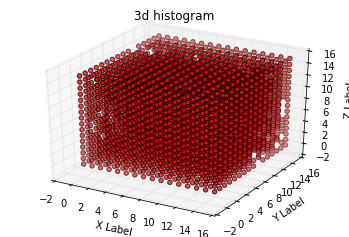

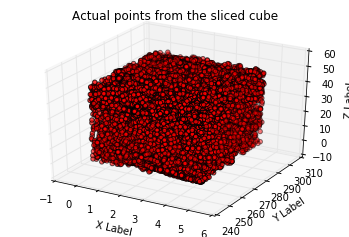

In [12]:
## Display the 3d histogram and compare with the original sliced cube
key = '50.0'
cube_dim=16
hists_3d = read_3d_hists_from_disk(PATH_WRITE, cube_id + str(box_num), key+'_100_(16, 16, 16).tfrecords')
print(hists_3d.shape)
x,y,z = hists_3d[50,:].nonzero() #display only non zero points from the histogram
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=x, ys=y, zs=z, c='r', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title("3d histogram")
plt.show()

small_cubes = read_small_cubes_from_disk(PATH_WRITE, cube_id + str(box_num), key+'.h5', 100)
small_cube = small_cubes[50]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=small_cube[:,0], ys=small_cube[:,1], zs=small_cube[:,2], c='r', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title("Actual points from the sliced cube")
plt.show()

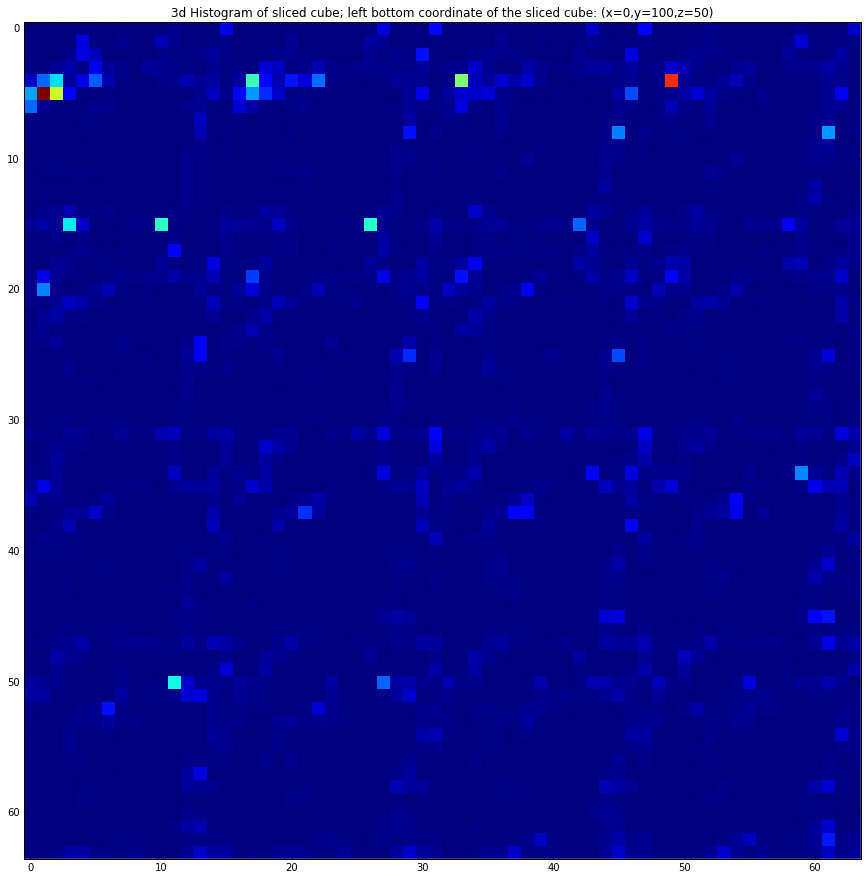

In [13]:
# display the 3d histogram slice by slice as 2d image
key = '50.0' + '_100_(16, 16, 16).tfrecords'
cube_dim=16
hists_3d = read_3d_hists_from_disk(PATH_WRITE, cube_id + str(box_num), key)
tile = utils.tile_cube_to_2d(hists_3d[0,:])
fig = plt.figure(figsize=(15,15))
plt.title("3d Histogram of sliced cube; left bottom coordinate of the sliced cube: (x=0,y=100,z=50)")
plt.imshow(tile, interpolation='none')

## TFRecordDataset

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from sklearn.datasets import make_spd_matrix as RAND_COV
import os, sys
import glob
import tensorflow as tf
import data

In [38]:
def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [39]:
train_addrs = glob.glob(PATH_WRITE + 'Box_350Mpch_0hist/' + '*.h5')

In [40]:
def save_as_tfrecord(l, h, train_filename):
    writer = tf.python_io.TFRecordWriter(train_filename)
    for i in range(l, h):
        # Load the 3d hist
        _, img = data.load_data_from_file(train_addrs[i])

        # Create a feature
        feature = {'train/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}
        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))

        # Serialize to string and write on the file
        writer.write(example.SerializeToString())
    
    writer.close()
    sys.stdout.flush()

In [42]:
train_filename1 = PATH_WRITE + 'tfrecord/' + 'train.tfrecords1'
train_filename2 = PATH_WRITE + 'tfrecord/' + 'train.tfrecords2'
save_as_tfrecord(0, 50, train_filename1)
save_as_tfrecord(50, 100, train_filename2)

In [41]:
def read_tfrecord(file_path):
    record_iterator = tf.python_io.tf_record_iterator(path=file_path)
    cubes = []
    for string_record in record_iterator:
        example = tf.train.Example()
        example.ParseFromString(string_record)

        img_string = (example.features.feature['train/image']
                                      .bytes_list
                                      .value[0])

        cube = np.fromstring(img_string, dtype=np.float32)
        cube = cube.reshape((16, 16, 16))
        cubes.append(cube)
        
    return cubes

In [14]:
def parser(serialized_example):
    """Parses a single tf.Example into image and label tensors."""
    parsed_features = tf.parse_single_example(
        serialized_example,
        features={
            'train/image': tf.FixedLenFeature([], tf.string)
        })
    
    image = parsed_features['train/image']
    image = tf.decode_raw(image, tf.float32)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [16,16,16])
    return image

In [15]:
filenames = [train_filename1, train_filename2]
#filenames = tf.placeholder(tf.string, shape=[None])
dataset = tf.data.TFRecordDataset(filenames)
dataset = dataset.map(parser)
dataset = dataset.batch(10)
iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

In [16]:
sess = tf.InteractiveSession()
value = []
for i in range(10):
    value.append( sess.run(next_element) )
    

In [17]:
actual = []
for i in range(100):
    _, img = data.load_data_from_file(train_addrs[i])
    actual.append(img)

In [18]:
actual[0] == value[0][0]

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr